In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configargparse
from aspire.volume import Volume
from aspire.utils.rotation import Rotation as aspire_Rotation
from scipy.spatial.transform import Rotation as scipy_Rotation
import numpy as np
import os
import logging
import time

from cryomap_align.utils import init_config, try_mkdir
from cryomap_align.vol_utils import center_vol
from cryomap_align.gauss_opt_utils import run_gaussian_opt
from cryomap_align.opt_refinement import run_nelder_mead_refinement

2023-12-18 10:05:33.710015: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 10:05:33.753136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-12-18 10:05:51,705 INFO [numexpr.utils] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-12-18 10:05:51,709 INFO [numexpr.utils] NumExpr defaulting to 8 threads.


I developed this module in a way that it would be easy for me to use in the future, so some of the functionalities it has are not useful for the project (like reading all my inputs from config files). For this reason I will have to do things in a non-optimal way below. This does not impact the method as it's just unimportant software stuff.

In [3]:
results_refine = np.load("results_with_refinement.npz")
results_noise = np.load("results_for_noise.npz")

In [4]:
def calc_error(mtx_stack1, mtx_stack2):
    cos_theta = (
        np.trace(
            np.matmul(mtx_stack1, mtx_stack2.transpose((0, 2, 1))), axis1=1, axis2=2
        )
        - 1
    ) / 2
    cos_theta[cos_theta > 1] = 1
    cos_theta[cos_theta < -1] = -1
    error = np.arccos(cos_theta) * (180) / np.pi

    return error

In [6]:
list(results_refine.keys())

['true_mtx',
 'optim_max_wemd',
 'refin_max_wemd',
 'optim_max_l2',
 'refin_max_l2',
 'run_time_wemd',
 'run_time_l2']

### Results for Bayesian Optimization vs Bayesian Optimization + refinement

In [5]:
error_optim = []
error_refin = []
run_time_optim = []
run_time_refin = []

for i in range(results_refine["true_mtx"].shape[1]):
    true_mtx = results_refine["true_mtx"][0, i]
    optim_mtx_wemd = results_refine["optim_max_wemd"][0, i]
    refin_mtx_wemd = results_refine["refin_max_wemd"][0, i]
    optim_mtx_l2 = results_refine["optim_max_l2"][0, i]
    refin_mtx_l2 = results_refine["refin_max_l2"][0, i]

    error_optim.append(calc_error(true_mtx, optim_mtx_wemd))
    error_refin.append(calc_error(true_mtx, refin_mtx_wemd))
    error_optim.append(calc_error(true_mtx, optim_mtx_l2))
    error_refin.append(calc_error(true_mtx, refin_mtx_l2))

    run_time_optim.append("WEMD \n" + str(results_refine["run_time_wemd"][0, i, :, 0].mean().round(1)))
    run_time_optim.append("L2 \n" + str(results_refine["run_time_l2"][0, i, :, 0].mean().round(1)))
    run_time_refin.append("WEMD \n" + str(results_refine["run_time_wemd"][0, i, :, 1].mean().round(1)))
    run_time_refin.append("L2 \n" + str(results_refine["run_time_l2"][0, i, :, 1].mean().round(1)))

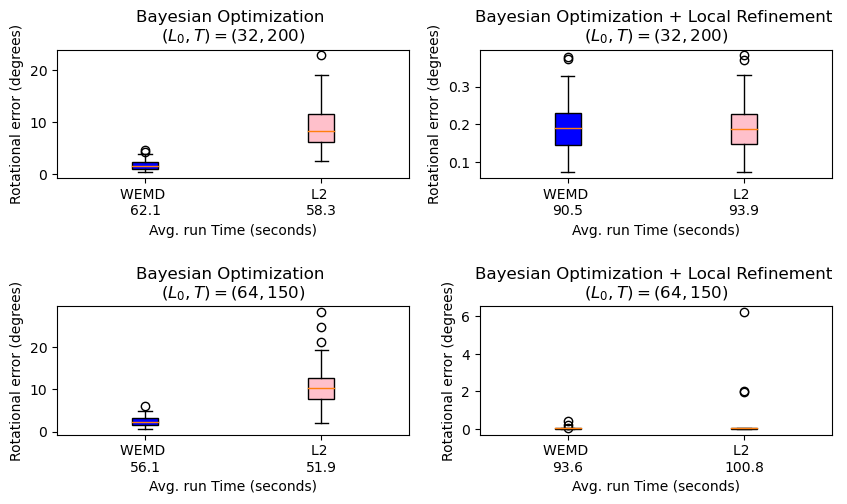

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 5))

bplot_00 = ax[0, 0].boxplot(error_optim[0:2], patch_artist=True, labels=run_time_optim[0:2])
bplot_01 = ax[0, 1].boxplot(error_refin[0:2], patch_artist=True, labels=run_time_refin[0:2])

bplot_10 = ax[1, 0].boxplot(error_optim[2:], patch_artist=True, labels=run_time_optim[2:])
bplot_11 = ax[1, 1].boxplot(error_refin[2:], patch_artist=True, labels=run_time_refin[2:])


for bplot in (bplot_00, bplot_01, bplot_10, bplot_11):
    for patch, color in zip(bplot["boxes"], ["blue", "pink"]):
        patch.set_facecolor(color)

ax[0, 0].set_xlabel("Avg. run Time (seconds)")
ax[0, 1].set_xlabel("Avg. run Time (seconds)")
ax[1, 0].set_xlabel("Avg. run Time (seconds)")
ax[1, 1].set_xlabel("Avg. run Time (seconds)")

ax[0, 0].set_ylabel("Rotational error (degrees)")
ax[0, 1].set_ylabel("Rotational error (degrees)")
ax[1, 0].set_ylabel("Rotational error (degrees)")
ax[1, 1].set_ylabel("Rotational error (degrees)")

ax[0, 0].set_title("Bayesian Optimization \n" + r"$(L_0, T) = (32, 200)$")
ax[0, 1].set_title("Bayesian Optimization + Local Refinement \n" + r"$(L_0, T) = (32, 200)$")
ax[1, 0].set_title("Bayesian Optimization \n" + r"$(L_0, T) = (64, 150)$")
ax[1, 1].set_title("Bayesian Optimization + Local Refinement \n" + r"$(L_0, T) = (64, 150)$")
plt.subplots_adjust(hspace=1.0)

fig.savefig("results_with_refinement.png", dpi=300, bbox_inches="tight")

### Results for added noise (refinement only)

In [13]:
noise_error_snr1 = []
noise_error_snr2 = []
run_time_snr1 = []
run_time_snr2 = []

for i in range(results_noise["true_mtx"].shape[0]):
    for j in range(results_noise["true_mtx"].shape[1]):
        true_mtx = results_noise["true_mtx"][i, j]
        refin_mtx_wemd = results_noise["refin_mtx_wemd"][i, j]
        refin_mtx_l2 = results_noise["refin_mtx_l2"][i, j]

        if i == 0:
            noise_error_snr1.append(calc_error(true_mtx, refin_mtx_wemd))
            noise_error_snr1.append(calc_error(true_mtx, refin_mtx_l2))
            run_time_snr1.append("WEMD \n" + str(results_noise["run_time_wemd"][i, j, :, 1].mean().round(1)))
            run_time_snr1.append("L2 \n" + str(results_noise["run_time_l2"][i, j, :, 1].mean().round(1)))

        elif i == 1:
            noise_error_snr2.append(calc_error(true_mtx, refin_mtx_wemd))
            noise_error_snr2.append(calc_error(true_mtx, refin_mtx_l2))
            run_time_snr2.append("WEMD \n" + str(results_noise["run_time_wemd"][i, j, :, 1].mean().round(1)))
            run_time_snr2.append("L2 \n" + str(results_noise["run_time_l2"][i, j, :, 1].mean().round(1)))

In [84]:
list(results_noise.keys())

['true_mtx',
 'optim_mtx_wemd',
 'refin_mtx_wemd',
 'optim_mtx_l2',
 'refin_mtx_l2',
 'run_time_wemd',
 'run_time_l2']

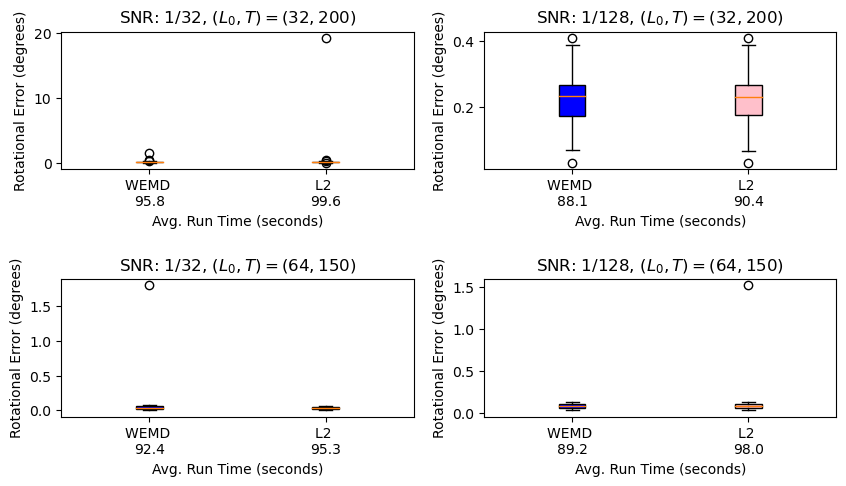

In [100]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

bplot_00 = ax[0, 0].boxplot(noise_error_snr1[:2], patch_artist=True, labels=run_time_snr1[:2])#, showfliers=False)
bplot_01 = ax[0, 1].boxplot(noise_error_snr2[:2], patch_artist=True, labels=run_time_snr2[:2])#, showfliers=False)
bplot_10 = ax[1, 0].boxplot(noise_error_snr1[2:], patch_artist=True, labels=run_time_snr1[2:])#, showfliers=False)
bplot_11 = ax[1, 1].boxplot(noise_error_snr2[2:], patch_artist=True, labels=run_time_snr2[2:])#, showfliers=False)


for bplot in (bplot_00, bplot_01, bplot_10, bplot_11):
    for patch, color in zip(bplot["boxes"], ["blue", "pink"]):
        patch.set_facecolor(color)

ax[0, 0].set_xlabel("Avg. Run Time (seconds)")
ax[0, 1].set_xlabel("Avg. Run Time (seconds)")
ax[1, 0].set_xlabel("Avg. Run Time (seconds)")
ax[1, 1].set_xlabel("Avg. Run Time (seconds)")

ax[0, 0].set_ylabel("Rotational Error (degrees)")
ax[1, 0].set_ylabel("Rotational Error (degrees)")
ax[0, 1].set_ylabel("Rotational Error (degrees)")
ax[1, 1].set_ylabel("Rotational Error (degrees)")

ax[0, 0].set_title("SNR: 1/32, with outliers")
ax[1, 0].set_title("SNR: 1/32, no outliers")
ax[0, 1].set_title("SNR: 1/128, with outliers")
ax[1, 1].set_title("SNR: 1/128, no outliers")

ax[0, 0].set_title("SNR: 1/32, " + r"$(L_0, T) = (32, 200)$")
ax[0, 1].set_title("SNR: 1/128, " + r"$(L_0, T) = (32, 200)$")
ax[1, 0].set_title("SNR: 1/32, " + r"$(L_0, T) = (64, 150)$")
ax[1, 1].set_title("SNR: 1/128, " + r"$(L_0, T) = (64, 150)$")
# set spacing between vertical plots
plt.subplots_adjust(hspace=0.8)

fig.savefig("results_for_noise.png", dpi=300, bbox_inches="tight")

### Plotting projections for different levels of noise

In [69]:
vol0 = Volume.load("volumes/emd_3683.map")

2023-12-18 14:38:21,743 INFO [aspire.volume.volume] volumes/emd_3683.map with dtype float32 loaded as None


In [88]:
from aspire.source import Simulation

angle = np.array([[0, np.pi/2, np.pi/2]])  # rotation angles

src = Simulation(
    n=1,  # number of projections
    vols=vol0,  # volume source
    offsets=0,  # Default: images are randomly shifted
    angles=angle,
)

image = src.projections[0]._data[0]

images = np.zeros((3, *image.shape))
images[0] = image

for i, snr in enumerate([1.0 / 32.0, 1.0 / 128.0]):

    noise_std = np.sqrt(
        np.linalg.norm(vol0._data[0]) ** 2 / (vol0._data.shape[1] ** 3 * snr)
    )

    vol = vol0 + np.random.normal(0, noise_std, vol0._data[0].shape).astype(
                        np.float32
    )


    image = src.projections[0]._data[0]
    images[i+1] = image

2023-12-18 14:47:18,182 INFO [aspire.source.image] Creating Simulation with 1 images.


2023-12-18 14:47:22,857 INFO [aspire.source.image] Creating Simulation with 1 images.
2023-12-18 14:47:27,394 INFO [aspire.source.image] Creating Simulation with 1 images.


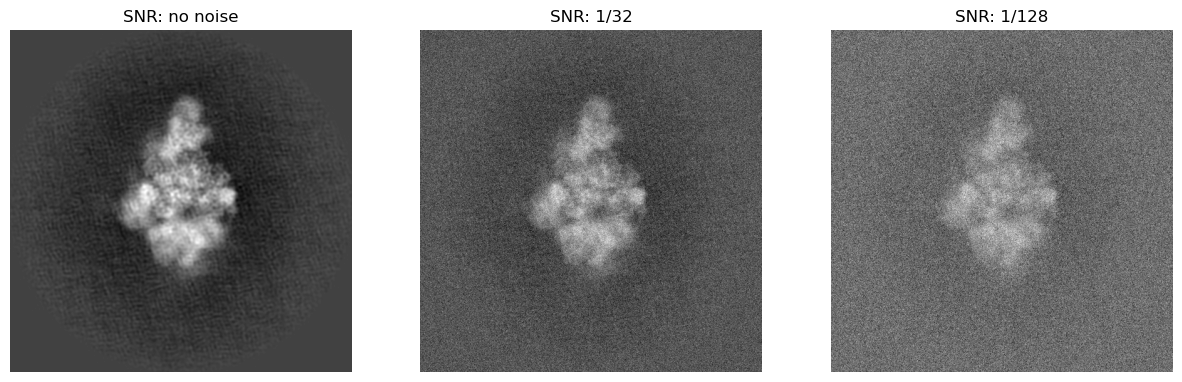

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
snrs = ["SNR: no noise", "SNR: 1/32", "SNR: 1/128"]

for i in range(3):
    ax[i].imshow(images[i], cmap="gray")
    ax[i].set_title(snrs[i])
    ax[i].axis("off")

fig.savefig("noise_examples.png", dpi=300, bbox_inches="tight")